In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import warnings

import geopandas as gpd
import geoplot as gplt

from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

from pathlib import Path

## Meta data

In [4]:
meta_data = pd.read_excel('../data/Papio-Genomes_JR_120720_MR-CR-KM.xlsx')
meta_data.head()

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex
0,PD_0067,1043,Roos,Theropithecus,gelada,captive,M
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F


Assign 'U' as unknown sex:

In [5]:
meta_data.loc[meta_data.Sex.isnull(), 'Sex'] = 'U'

Set https proxy. Jupyter does not inherrit the one set set for other shells.

In [6]:
%env https_proxy=http://in:3128 

env: https_proxy=http://in:3128


Automacially retrieve geolocations:

In [7]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="baboon_map")
geolocations = dict()
unidentifiable = set()
for loc in meta_data.Origin:
    geoloc = geolocator.geocode(loc)
    if geoloc:
        geolocations[loc] = geoloc
    else:
        unidentifiable.add(loc)

Unidentifiable locations:

In [8]:
unidentifiable

{'Dendro Park, Zambia',
 'Filoha, Ethiopia',
 'Gog Woreda, Gambella region, Ethiopia'}

Get the last ones manually...

In [9]:
class dummy_geo():
    def __init__(self, *args, **kwargs):
        for key, val in kwargs.items():
            setattr(self, key, val)
manual_geolocations = dict()
manual_geolocations['Dendro Park, Zambia'] = dummy_geo(
    address='Dendro Balla Balla Safaris, Namwala, Zambia', 
    latitude=-16.145437871122923, longitude=26.062549952570674)
manual_geolocations['Filoha, Ethiopia'] = dummy_geo(
    address='Awash National Park in Ethiopia', 
    latitude=9.083582259300927, longitude=40.00000536178701)
manual_geolocations['Gog Woreda, Gambella region, Ethiopia'] = dummy_geo(
    address='Gambrella National Park, Ethiopia', 
    latitude=8.07396896853714, longitude=34.17906287308874)

Add manual geolocations:

In [10]:
geolocations.update(manual_geolocations)

Augment meta data with geolocations:

In [11]:
meta_data['address'] = [geolocations[loc].address for loc in meta_data.Origin]                                      
meta_data['longitude'] = [geolocations[loc].longitude for loc in meta_data.Origin]                                      
meta_data['latitude'] = [geolocations[loc].latitude for loc in meta_data.Origin]                                                           

In [12]:
meta_data.head()

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude
0,PD_0067,1043,Roos,Theropithecus,gelada,captive,M,"SDSU Captive Wildlife Research Facility, Brook...",-96.793280,44.334031
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626


In [13]:
meta_data.to_excel('../data/Papio-Genomes_JR_120720_MR-CR-KM_geoloc.xlsx')

In [14]:
meta_data = pd.read_excel('../data/Papio-Genomes_JR_120720_MR-CR-KM_geoloc.xlsx')

## Colors

In [15]:
mycols = sns.color_palette(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00','#6a3d9a', 'deeppink'])
mycols_cmap = ListedColormap(mycols.as_hex())
mycols

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (1.0, 0.4980392156862745, 0.0),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 0.0784313725490196, 0.5764705882352941)]

## Baboon range data

In [16]:
geodata_dir = Path('../data/baboon_range_shape_data')
ranges_gdf = pd.concat(gpd.read_file(path) for path in geodata_dir.glob('**/*.shp'))


In [17]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

# africa = world[world.continent == 'Africa']
africa = world[(world.continent == 'Africa') | (world.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
                           'Israel', 'Jordan', 'Qatar', 'Kuwait']))]

## Clean map

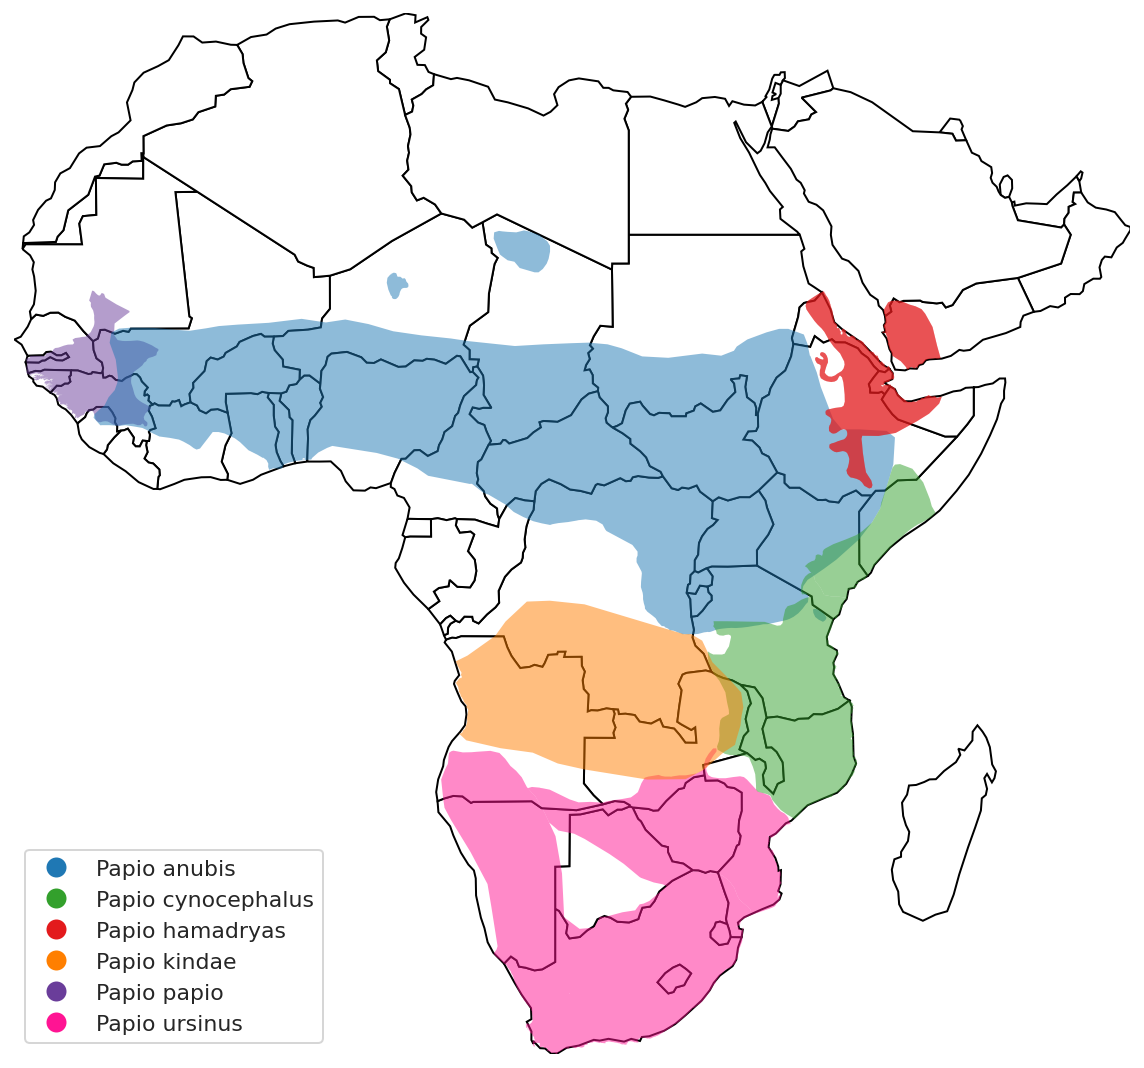

In [18]:
# world.loc[world.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
#                            'Israel', 'Jordan', 'Qatar', 'Kuwait'])]

ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
plt.savefig('../figures/ranges.pdf')

## GeoDataFrame

In [19]:
gdf = gpd.GeoDataFrame(meta_data, geometry=gpd.points_from_xy(meta_data.longitude, meta_data.latitude))
gdf.head()

,Unnamed: 0,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,geometry
0,0,PD_0067,1043,Roos,Theropithecus,gelada,captive,M,"SDSU Captive Wildlife Research Facility, Brook...",-96.793280,44.334031,POINT (-96.79328 44.33403)
1,1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,POINT (34.74254 -1.99663)
2,2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,POINT (34.74254 -1.99663)
3,3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,POINT (34.74254 -1.99663)
4,4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,POINT (34.74254 -1.99663)


## Sampling locations for each species

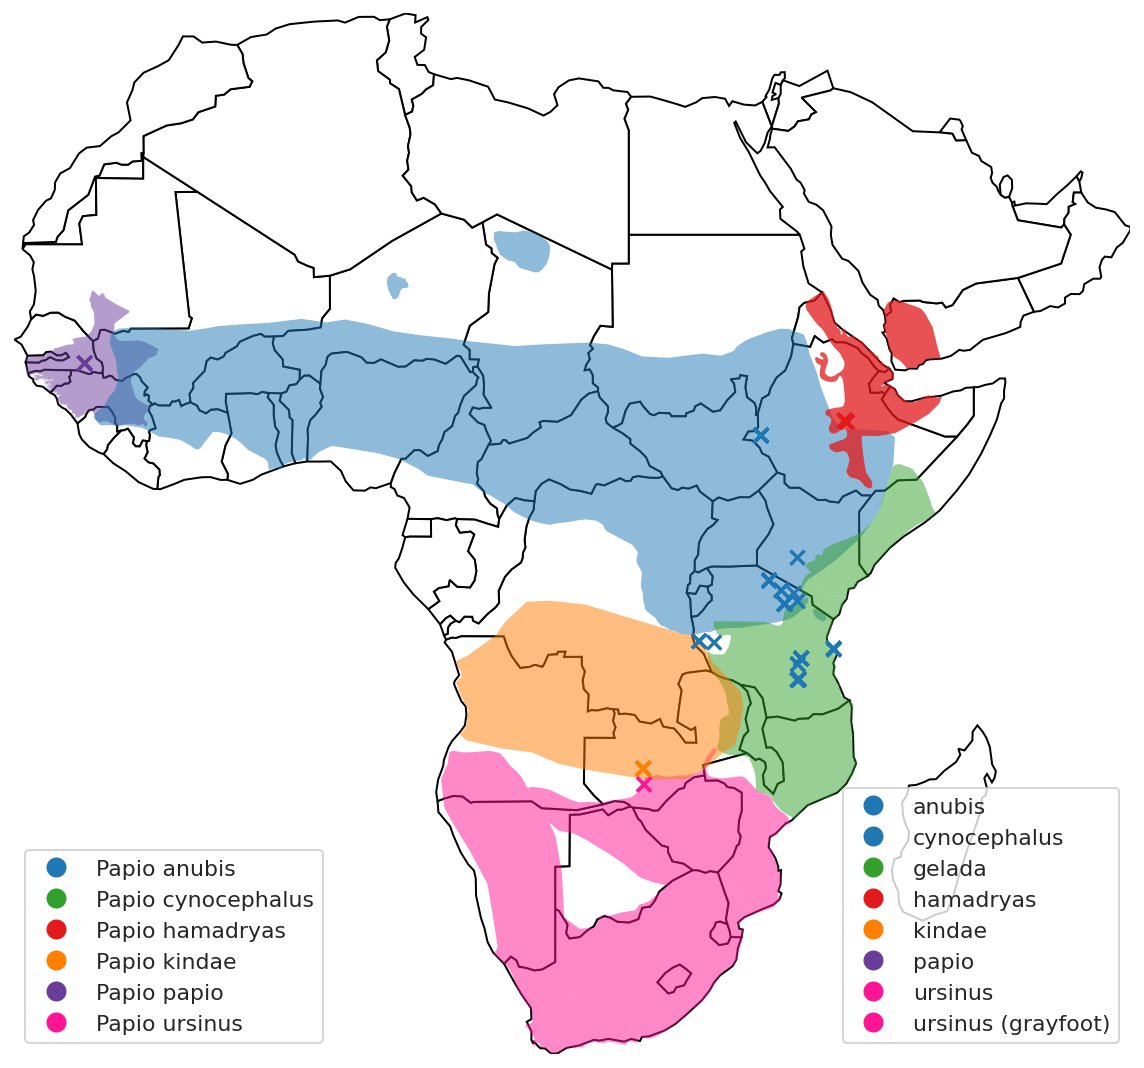

In [20]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

# overwrites first legend
gplt.pointplot(gdf, ax=ax, extent=africa.total_bounds, marker='x',
               zorder=10, s=7, hue='Species', legend=True, cmap=mycols_cmap, 
              legend_kwargs=dict(loc='lower right'));

# manually add the first legend back
ax.add_artist(leg1); 

## Plot with each sample as male or female

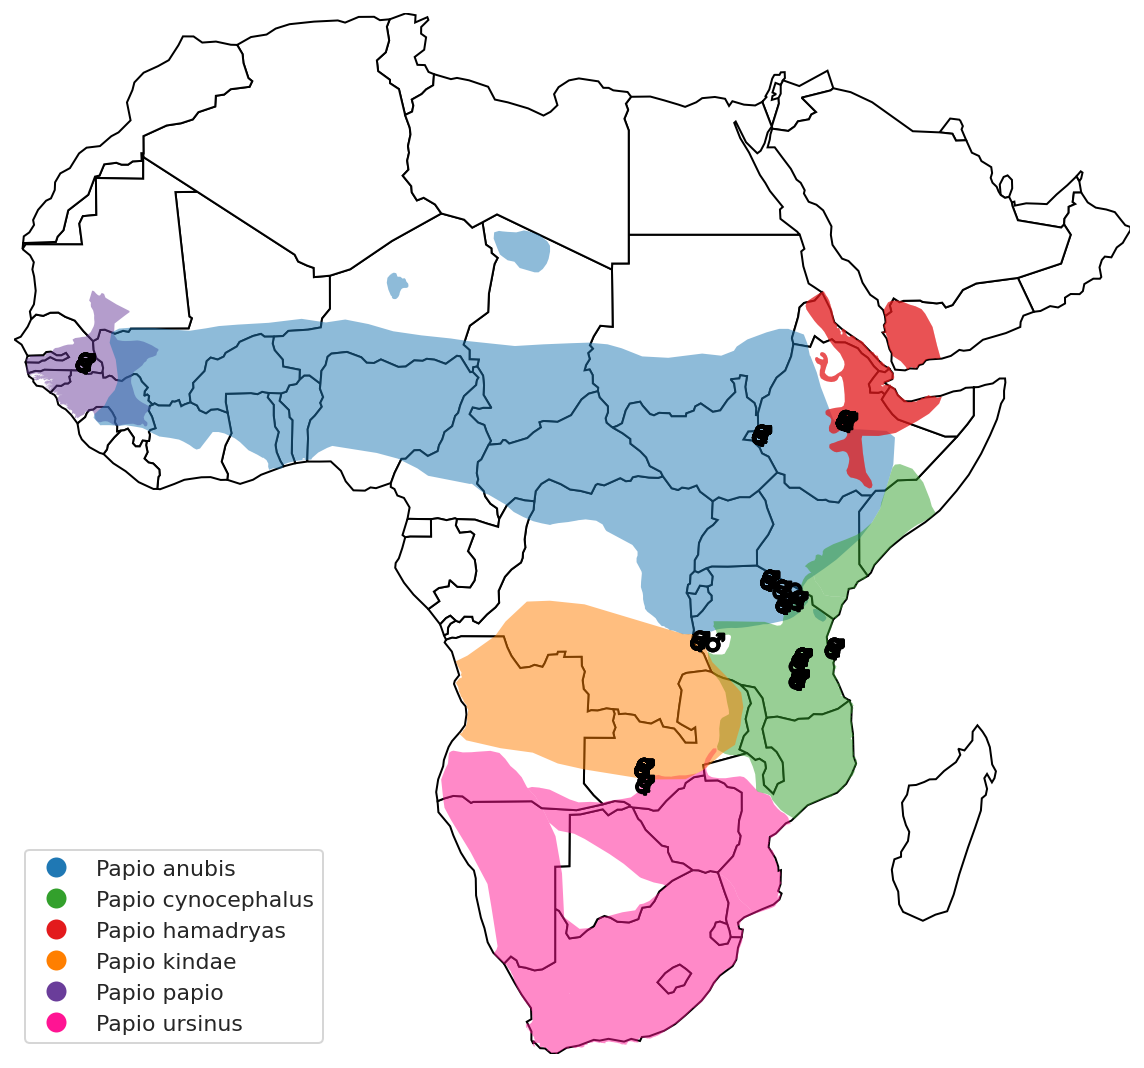

In [21]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;

gplt.pointplot(gdf.loc[gdf.Sex=='F'], ax=ax, extent=africa.total_bounds, marker="$\u2640$",
               zorder=10, s=10, color='black');
gplt.pointplot(gdf.loc[gdf.Sex=='M'], ax=ax, extent=africa.total_bounds, marker="$\u2642$",
               zorder=10, s=10, color='black');

In [22]:
gdf['dummy'] = np.random.random(gdf.index.size)

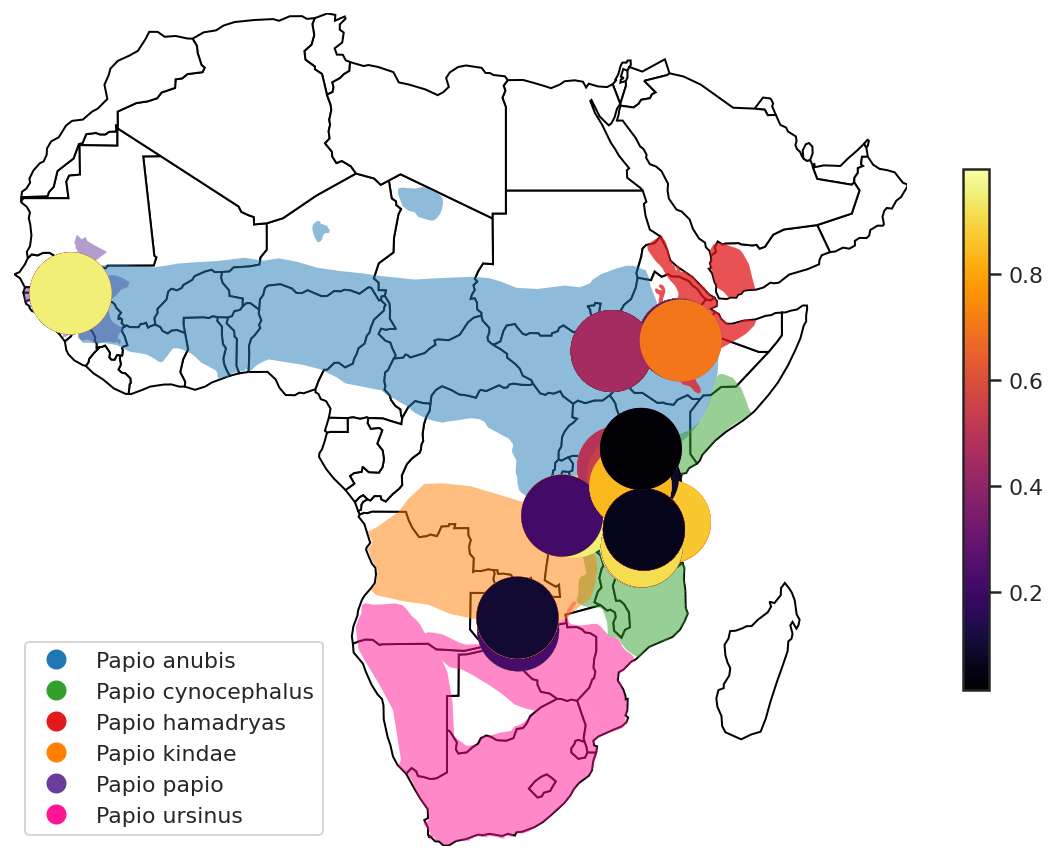

In [23]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;

gplt.pointplot(gdf, ax=ax, extent=africa.total_bounds, marker='o', #scheme=None,
               zorder=10, s=40, hue='dummy', legend=True, 
               legend_kwargs=dict(shrink=0.4), 
               cmap='inferno');

## Numbers of samples at each location

In [24]:
geo_loc = (gdf[['Origin', 'Species', 'Sex', 'geometry']]
           .dissolve(by=["Origin", 'Species'], 
                     aggfunc='count').rename(columns={'Sex': 'nr_samples'})
           .reset_index()
          )
geo_loc

,Origin,Species,geometry,nr_samples
0,"Aberdare, Kenya",anubis,POINT (36.71245 -0.41025),2
1,"Arusha, Tanzania",anubis,POINT (36.70858 -3.42753),4
2,"Awash, Ethiopia",hamadryas,POINT (40.16767 8.99250),2
3,"Chunga, Zambia",kindae,POINT (26.00521 -15.05356),28
4,"Dendro Park, Zambia",ursinus (grayfoot),POINT (26.06255 -16.14544),4
5,"Filoha, Ethiopia",hamadryas,POINT (40.00001 9.08358),24
6,"Gog Woreda, Gambella region, Ethiopia",anubis,POINT (34.17906 8.07397),25
7,"Gombe, Tanzania",anubis,POINT (36.79745 -8.85799),17
8,"Issa Valley, Tanzania",cynocephalus,POINT (36.46530 -2.87269),1
9,"Katavi, Tanzania",cynocephalus,POINT (30.92783 -6.30155),2


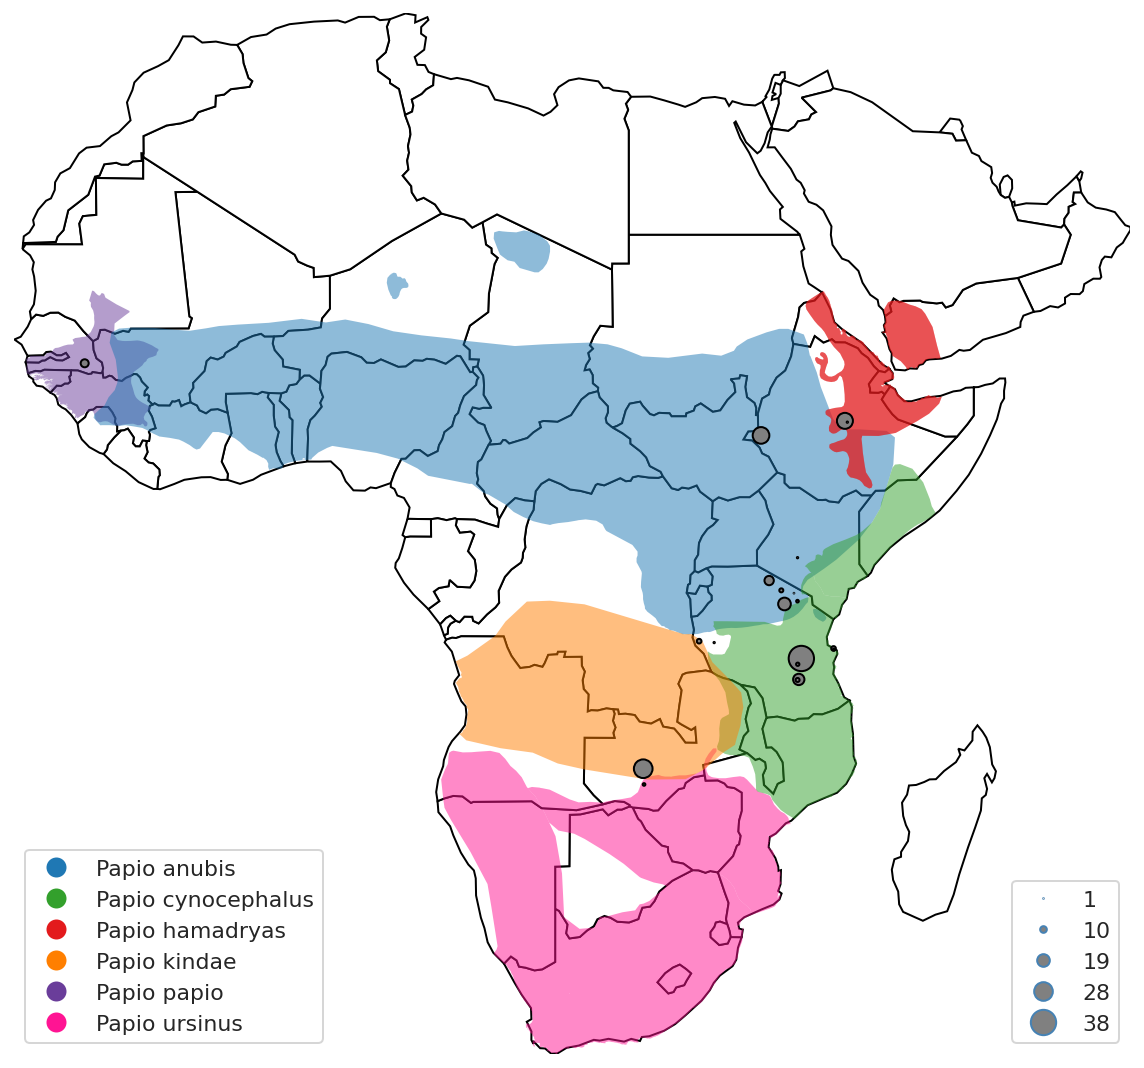

In [25]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 3
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right'),
              );

# manually add the first legend back
ax.add_artist(leg1); 

## Numbers of males sampled at each location

In [26]:
geo_loc = (gdf.loc[gdf.Sex == 'M', ['Origin', 'Species', 'Sex', 'geometry']]
           .dissolve(by=["Origin", 'Species'], 
                     aggfunc='count').rename(columns={'Sex': 'nr_samples'})
           .reset_index()
          )
geo_loc

,Origin,Species,geometry,nr_samples
0,"Arusha, Tanzania",anubis,POINT (36.70858 -3.42753),2
1,"Awash, Ethiopia",hamadryas,POINT (40.16767 8.99250),1
2,"Chunga, Zambia",kindae,POINT (26.00521 -15.05356),19
3,"Dendro Park, Zambia",ursinus (grayfoot),POINT (26.06255 -16.14544),1
4,"Filoha, Ethiopia",hamadryas,POINT (40.00001 9.08358),19
5,"Gog Woreda, Gambella region, Ethiopia",anubis,POINT (34.17906 8.07397),17
6,"Gombe, Tanzania",anubis,POINT (36.79745 -8.85799),7
7,"Katavi, Tanzania",cynocephalus,POINT (30.92783 -6.30155),2
8,"Lake Manyara, Tanzania",anubis,POINT (35.80649 -3.62221),4
9,"Mahale, Tanzania",cynocephalus,POINT (29.88343 -6.20329),5


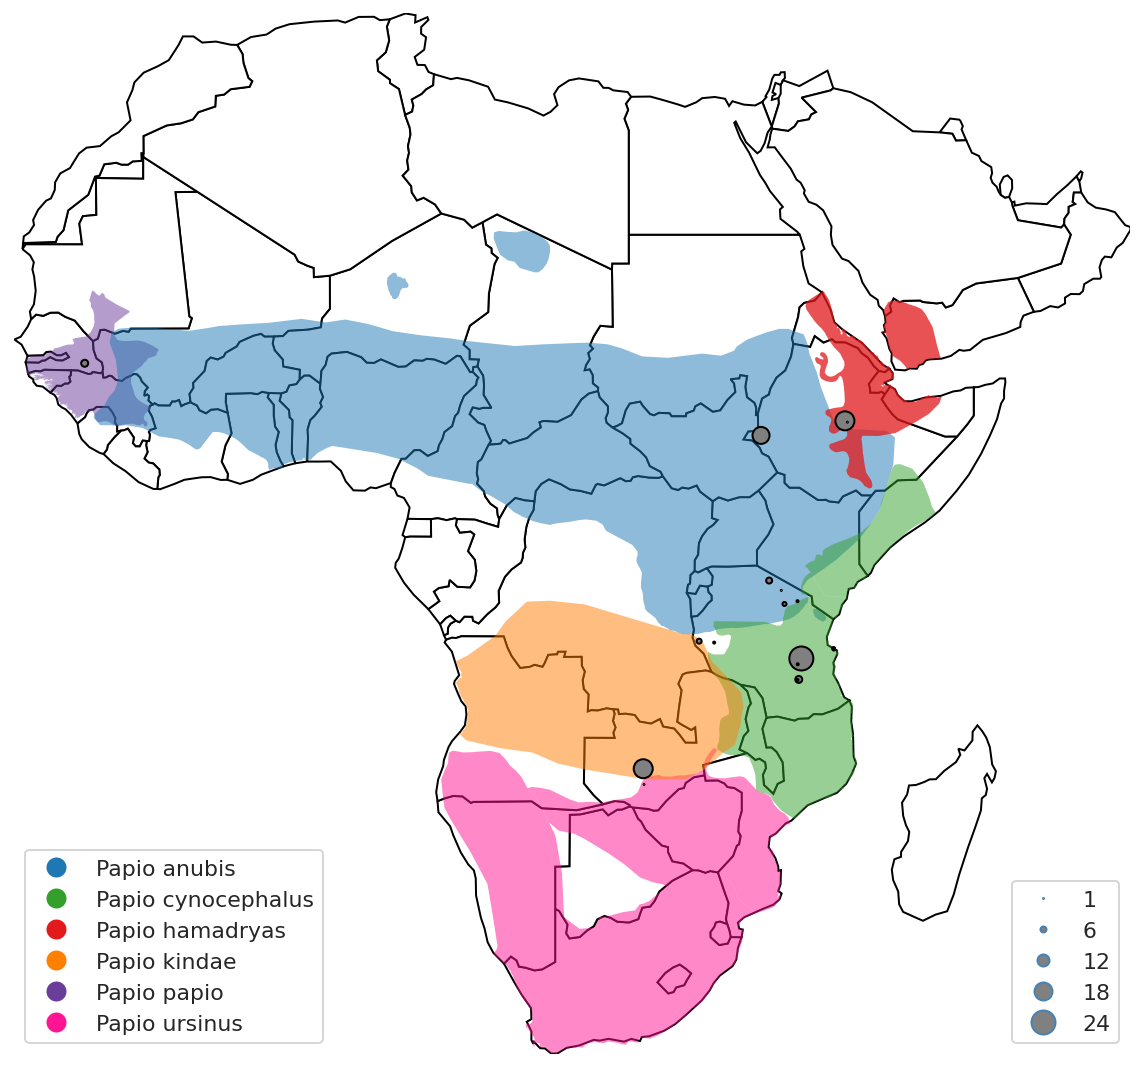

In [27]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 2
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right'),
              );

# manually add the first legend back
ax.add_artist(leg1); 

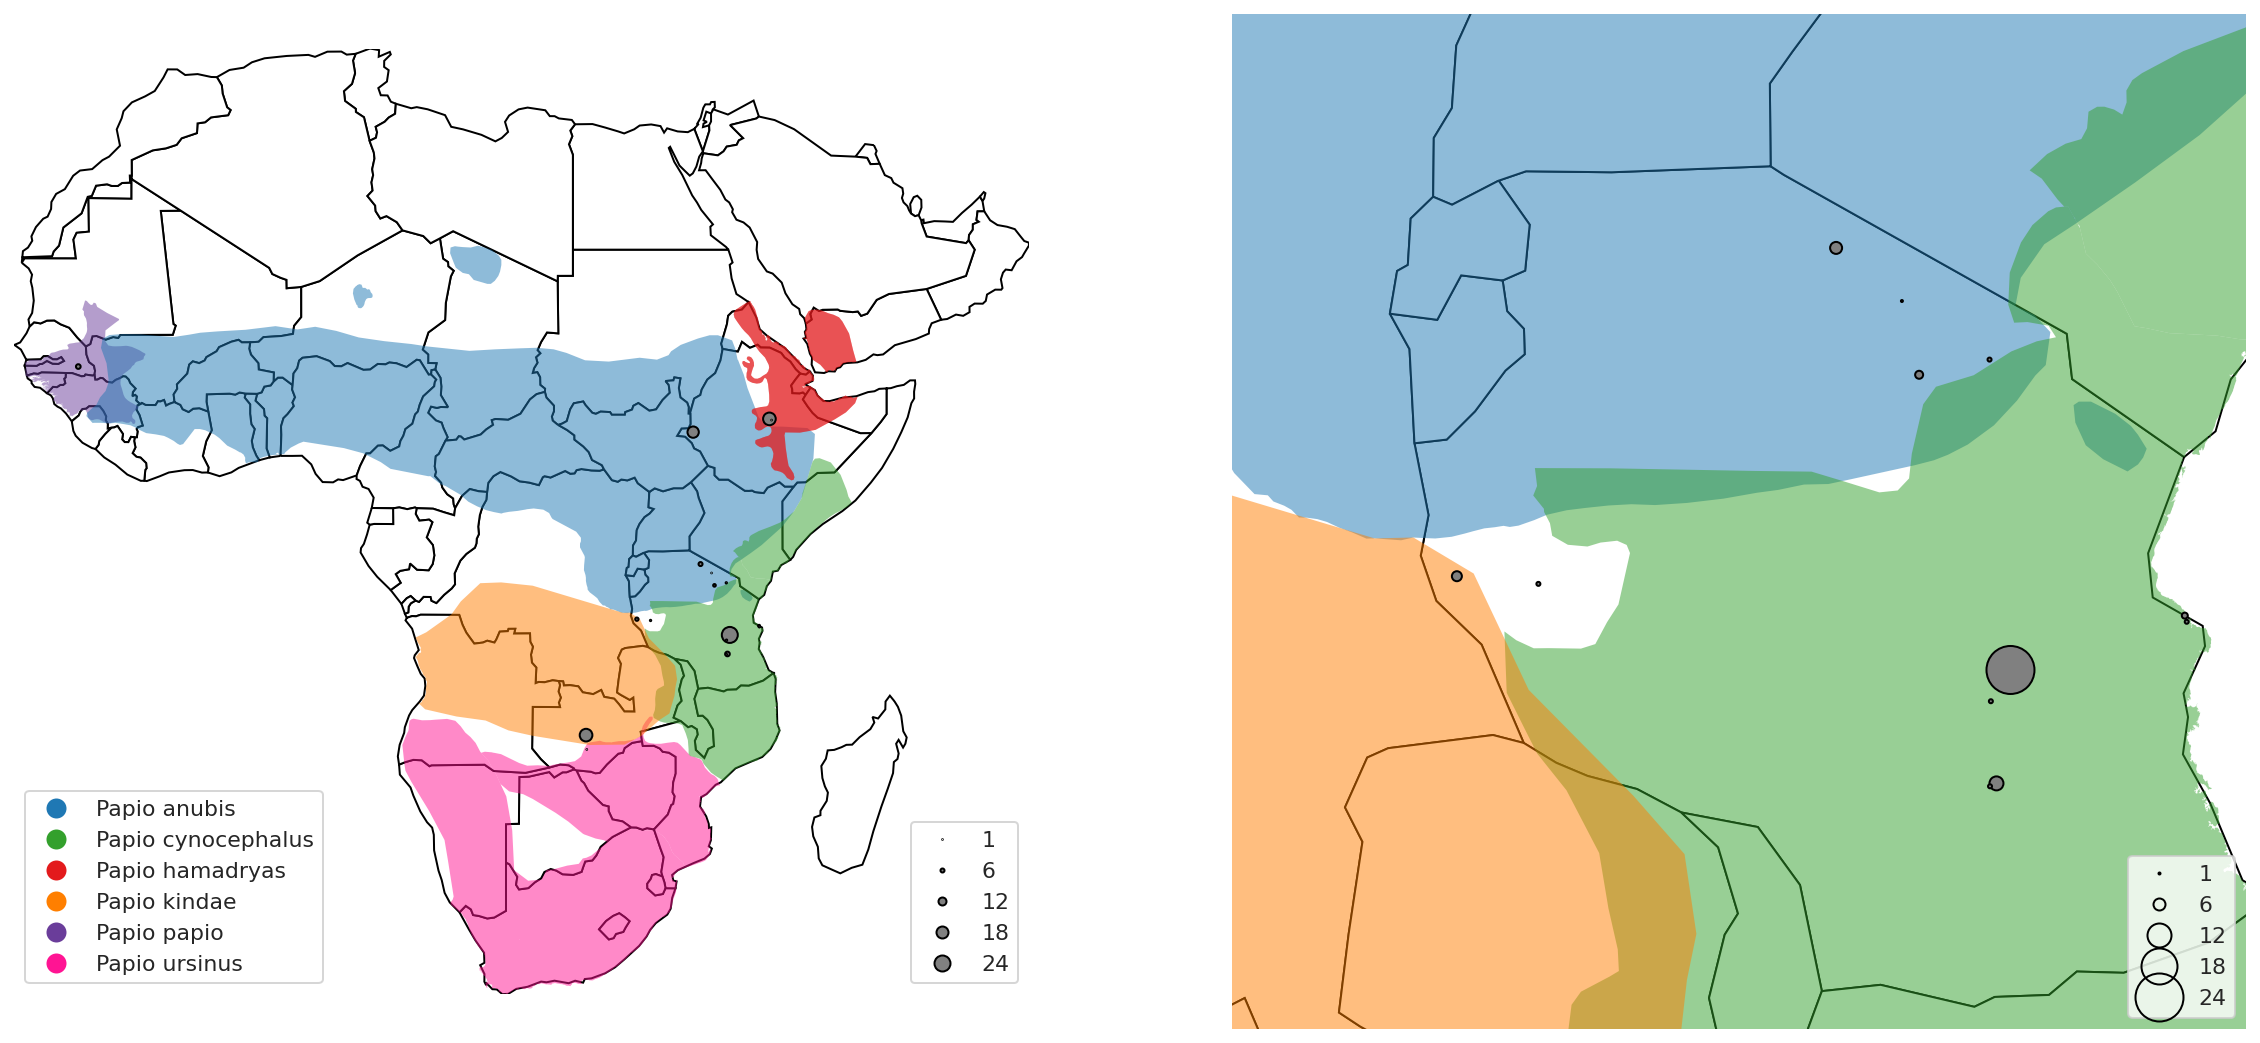

In [28]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 12))


ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', ax=ax)
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 3
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right', markeredgecolor='black'),
              );

# manually add the first legend back
ax.add_artist(leg1); 


ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', ax=ax2)
ax.set_facecolor('white')

extent = (27, -12, 40, 1)

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax2, 
    extent=extent,
    cmap=mycols_cmap, legend=True,
) ;
# get legend
leg1 = ax2.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax2, extent=extent,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right', markeredgecolor='black', markerfacecolor='none'),
              );
plt.savefig('../figures/baboon_samples.pdf')